In [1]:
import numpy as np
from scipy.linalg import eigvalsh_tridiagonal
from matplotlib import pyplot as plt

from IPython.display import clear_output

# Variational Principle for 1d Dirac Operators

### Some theory and notation

We are interested in the eigenvalues of the family of 1d Dirac operators $(T(t))_{t\in J}$ where $J$ is some interval and 
$$ T(t)
   :=
   \begin{pmatrix}
      0 & \frac{\mathrm d}{\mathrm d x} \\
      -\frac{\mathrm d}{\mathrm d x}  & 0
   \end{pmatrix}
   +
   \begin{pmatrix}
      M_1(x,t), & W(x) \\
      W(x) & -M_2(x,t)
   \end{pmatrix},\qquad x\in \mathbb{R}.
$$
We assume that the functions $M_j, W$ satisfy:

- For all $t\in J$, the functions $x\longmapsto W(x)$ and $x\longmapsto M_j(x,t)$ are bounded.

- For all $t\in J$, the limits $W_\pm:=\lim_{x\to\pm\infty}W(x)$, $M_{j\pm}(t):=\lim_{x\to\pm\infty}M_j(x,t)$ exists.

- For all $t\in J$, $-m_2(t)>m_1(t)$ where $m_i(t):=\inf_{x\in \mathbb{R}}M_i(x,t)$.

- For all $x\in\mathbb{R}$, the function $t\longmapsto M_1(x,t)$ is continuous and decreasing and $t\longmapsto M_2(x,t)$ is continuous and increasing.

For any given $t\in J$, the eigenvalues of the operator $T(t)$ in the interval $[m_1(t),\lambda_{e+}(t))$ coincide (with the same multiplicities) with those of the operator pencil $\lambda\longmapsto S(\lambda,t)$ where
$$\lambda_{e+}(t):=\min\left\{ \frac{M_{1\pm}(t) - M_{2\pm}(t)}{2} + \sqrt{ \left( \frac{M_{1\pm}(t) + M_{2\pm}(t)}{2} \right)^2 + W_\pm^2}\right\},$$
and
$$S(\lambda,t):=M_1(x,t)-\lambda+\left(\frac{\mathrm d}{\mathrm d x}+W(x)\right)\frac{1}{M_2(x,t)+\lambda}\left(-\frac{\mathrm d}{\mathrm d x}+W(x)\right),\qquad x\in \mathbb{R}.$$

Moreover, such eigenvalues $\lambda_n(t)$ are continuous and decreasing in $t$.

### The method

Precision parameters: ``R, n, step, tolerance``

We replace $\mathbb{R}$ with the interval $(-R,R)$ where we set $n-1$ equidistant nodes $x_i$ and work with the associated $L^2$ normalized finite element "basis" $\phi_i$ given by
$$h:=\frac{2 R}{n},\qquad\phi(x):=\frac{\chi_{[-h,h]}(x)}{\sqrt{2h/3}}\left(1-\frac{|x|}{h}\right),$$

$$\phi_i(x):=\phi(x - x_i),\qquad x_i:=-R + (i+1)h,\qquad i=0,...,n-2.$$

The advantage of this "basis" that $\phi_i,\phi_j$ have disjointed supports for $|i-j|\geq2$.

In [2]:
R = 20
n = 1000
h = 2 * R / n
X = [-R + (i + 1) * h for i in range(n - 1)]

We define the functions $M_1(x,t)$, $M_2(x,t)$, $W(x)$, and the corresponding $m_1(t)$, $\lambda_{e+}(t)$, as well as the quantities $\langle S(\lambda,t)\phi_i,\phi_i\rangle$ and $\langle S(\lambda,t)\phi_i,\phi_{i+1}\rangle$.

In [3]:
def M1(x, t):
    return 1 - (t / 2) * np.exp(-np.abs(x))


def M2(x, t):
    return 1 + (t / 2) * np.exp(-np.abs(x))


def W(x):
    return 0 * np.ones_like(x)


def m1(t):
    return 1 - (t / 2)


def le(t):
    return 1 * np.ones_like(t)


# These are not the actual integrals but approximations based on piecewise linear
# interpolation over the nodes x_i.
def S_d(l, t, i):
    x = X[i]
    return (3 / (2 * h)) * (
        (h / 12) * ((M1(x - h, t) - l) + 6 * (M1(x, t) - l) + (M1(x + h, t) - l))
        + (1 / h)
        * (0.5 / (M2(x - h, t) + l) + 1 / (M2(x, t) + l) + 0.5 / (M2(x + h, t) + l))
        + (1 / 3) * (-W(x - h) / (M2(x - h, t) + l) + W(x + h) / (M2(x + h, t) + l))
        + (h / 12)
        * (
            W(x - h) ** 2 / (M2(x - h, t) + l)
            + 6 * W(x) ** 2 / (M2(x, t) + l)
            + W(x + h) ** 2 / (M2(x + h, t) + l)
        )
    )


def S_e(l, t, i):
    x = X[i]
    return (3 / (2 * h)) * (
        (h / 12) * ((M1(x, t) - l) + (M1(x + h, t) - l))
        - (1 / (2 * h)) * (1 / (M2(x, t) + l) + 1 / (M2(x + h, t) + l))
        + (1 / 6) * (-W(x) / (M2(x, t) + l) + W(x + h) / (M2(x + h, t) + l))
        + (h / 12) * (W(x) ** 2 / (M2(x, t) + l) + W(x + h) ** 2 / (M2(x + h, t) + l))
    )

For each $(\lambda,t)$ we construct a symmetric tridiagonal matrix associated to $S(\lambda,t)$ restricted to our "basis". If this matrix has an eigenvalue of absolute value less than ``tolerance``,  then we say that $\lambda$ is an eigenvalue of $T(t)$. We cover all possible pairs $(t,\lambda)$ using steps of size ``step``.

For the first (left-most) $t\in J$ we run trough all possible $\lambda\in[m_1(t),\lambda_{e+}(t))$ in search for eigenvalues. However, for all subsequent $t$, knowing that the eigenvalues $\lambda_n(t)$ are continuous and decreasing in $t$, we only need to look in a neighborhood bellow the previously found eigenvalues, in addition to $\lambda_{e+}(t)$.

In [4]:
step = 0.005
tolerance = 0.005

J = np.arange(0, 4, step)  # interval for t.

T = []
L = []

t = J[0]
l = le(t) - step
while l >= m1(t):
    clear_output(wait=True)
    print("(t, l) = (" + str(t) + ", " + str(l) + ")")
    print("len(T) = " + str(len(T)))

    d = np.array([S_d(l, t, i) for i in range(n - 1)])
    e = np.array([S_e(l, t, i) for i in range(n - 2)])
    w = list(eigvalsh_tridiagonal(d, e, "v", [-tolerance, tolerance]))
    if len(w) > 0:
        T.append(t)
        L.append(l)
    l -= step

for t in J[1:]:
    aux = [le(t) - step]
    if len(T) > 0:
        aux += [L[i] for i in range(len(T)) if T[i] == T[-1]]

    neighborhood = []
    for i in range(0, 2):
        neighborhood += [j - i * step for j in aux]
    neighborhood = [i for i in neighborhood if i >= m1(t)]
    neighborhood.sort(reverse=True)
    neighborhood = set(neighborhood)

    for l in neighborhood:
        clear_output(wait=True)
        print("(t, l) = (" + str(t) + ", " + str(l) + ")")
        print("len(T) = " + str(len(T)))

        d = np.array([S_d(l, t, i) for i in range(n - 1)])
        e = np.array([S_e(l, t, i) for i in range(n - 2)])
        w = list(eigvalsh_tridiagonal(d, e, "v", [-tolerance, tolerance]))
        if len(w) > 0:
            T.append(t)
            L.append(l)

(t, l) = (3.995, 0.024999999999999183)
len(T) = 1791


We graph!

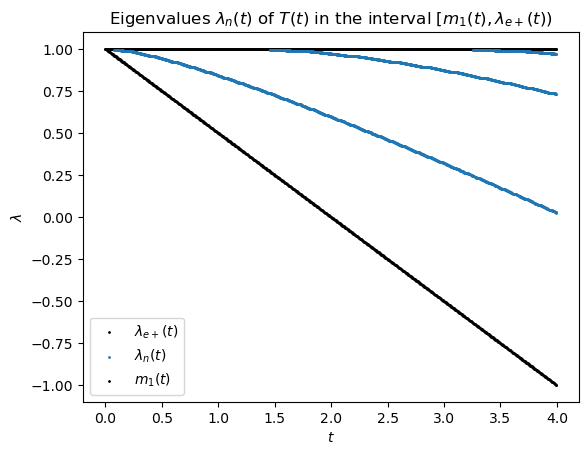

In [5]:
plt.scatter(J, le(J), s=1, color="black", label=r"$\lambda_{e+}(t)$")
plt.scatter(T, L, s=1, label=r"$\lambda_n(t)$")
plt.scatter(J, m1(J), s=1, color="black", label=r"$m_1(t)$")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\lambda$")
plt.title(
    r"Eigenvalues $\lambda_n(t)$ of $T(t)$ in the interval $[m_1(t),\lambda_{e+}(t))$"
)
plt.show()

And then save.

In [6]:
np.savetxt("data.csv", np.column_stack((T, L)), delimiter=",", header="t,l")